In [28]:
from typing import Union
import numpy as np
import pandas as pd
import numpy.typing as npt
from typing import Tuple
from tqdm import tqdm
from matplotlib import pyplot as plt
from simulations.stochastic_models import StochasticModels
from utility.types import StochasticModelEnum
from utility.math_equations import (
    compute_currrent_step_log_price,
    compute_next_step_log_vol,
    compute_current_price,
    compute_current_variance,
)
from data_provider.data_provider import DataProvider
from filters.kalman_filter import LinearKalmanFilterND
from filters.unscented_kalman_filter import UnscentedKalmanFilter
from filters.ssm import HestonDSSM

In [41]:

# df = DataProvider.get_stochastic_fake_data(total_points=1000)
# df.head()
df = pd.read_excel('../data/Data_apple_ibm.xlsx', sheet_name='APPLE_1min',names=['Date',"prices"])
df["returns"] = df.prices.pct_change().fillna(0)
df["variance"] = df.returns.rolling(100).var()
df["vol"] = df.returns.rolling(100).std().apply(lambda x: x * np.sqrt(252*60*6.5))
df["volvol"] = df.vol.rolling(100).std()
df = df.dropna().reset_index(drop=True)
df.head()

,Date,prices,returns,variance,vol,volvol
0,2024-01-02 13:45:00,188.90,0.000000,2.187464e-07,0.146623,0.022202
1,2024-01-02 13:46:00,188.90,0.000000,2.155420e-07,0.145545,0.022090
2,2024-01-02 13:47:00,188.90,0.000000,2.155420e-07,0.145545,0.021974
3,2024-01-02 13:48:00,188.88,-0.000106,2.155696e-07,0.145555,0.021851
4,2024-01-02 13:49:00,188.85,-0.000159,2.129898e-07,0.144681,0.021715


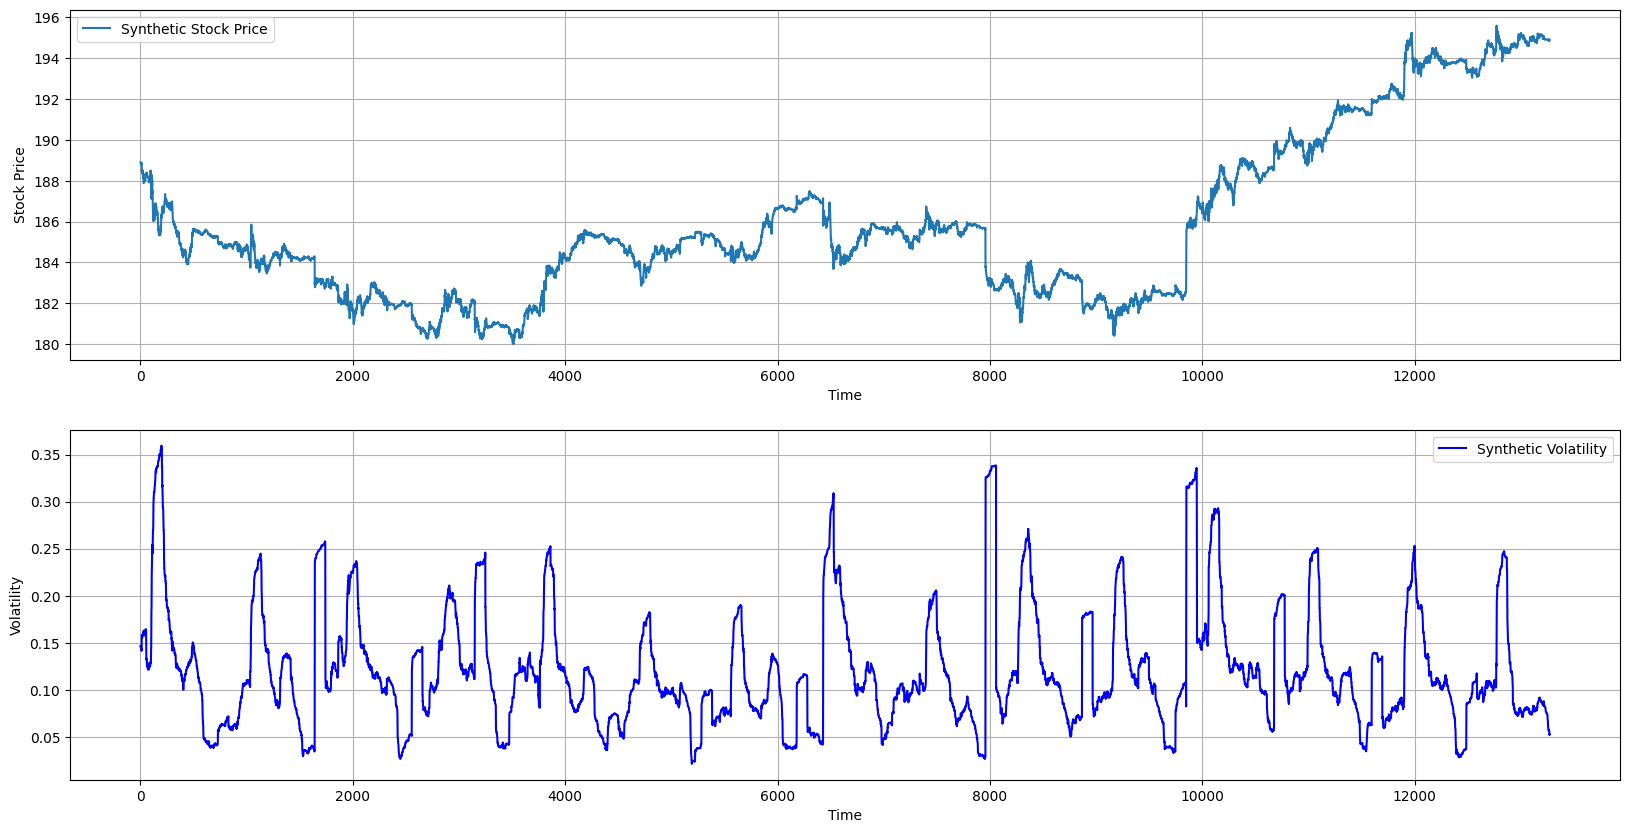

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].plot(df.prices, label="Synthetic Stock Price")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Stock Price")
ax[0].legend()
ax[0].grid()

ax[1].plot(df.vol, color="blue", label="Synthetic Volatility")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Volatility")
ax[1].legend()
ax[1].grid()

In [ ]:
Z = df[["prices", "variance"]].to_numpy()


ukf = UnscentedKalmanFilter(
    dim_x=Z.shape[-1],
    dim_z=Z.shape[-1],
    Q=np.array([[5, 0.0], [0.0, 10]]),
    R=np.array([[5, 0.0], [0.0, 10]]),
)


def f(x, u, v):
    return x + u + v


def h(x, u, n):
    return x + u + n


X_hat, _ = ukf.fit_predict(f, h, z=Z, x0=Z[0])


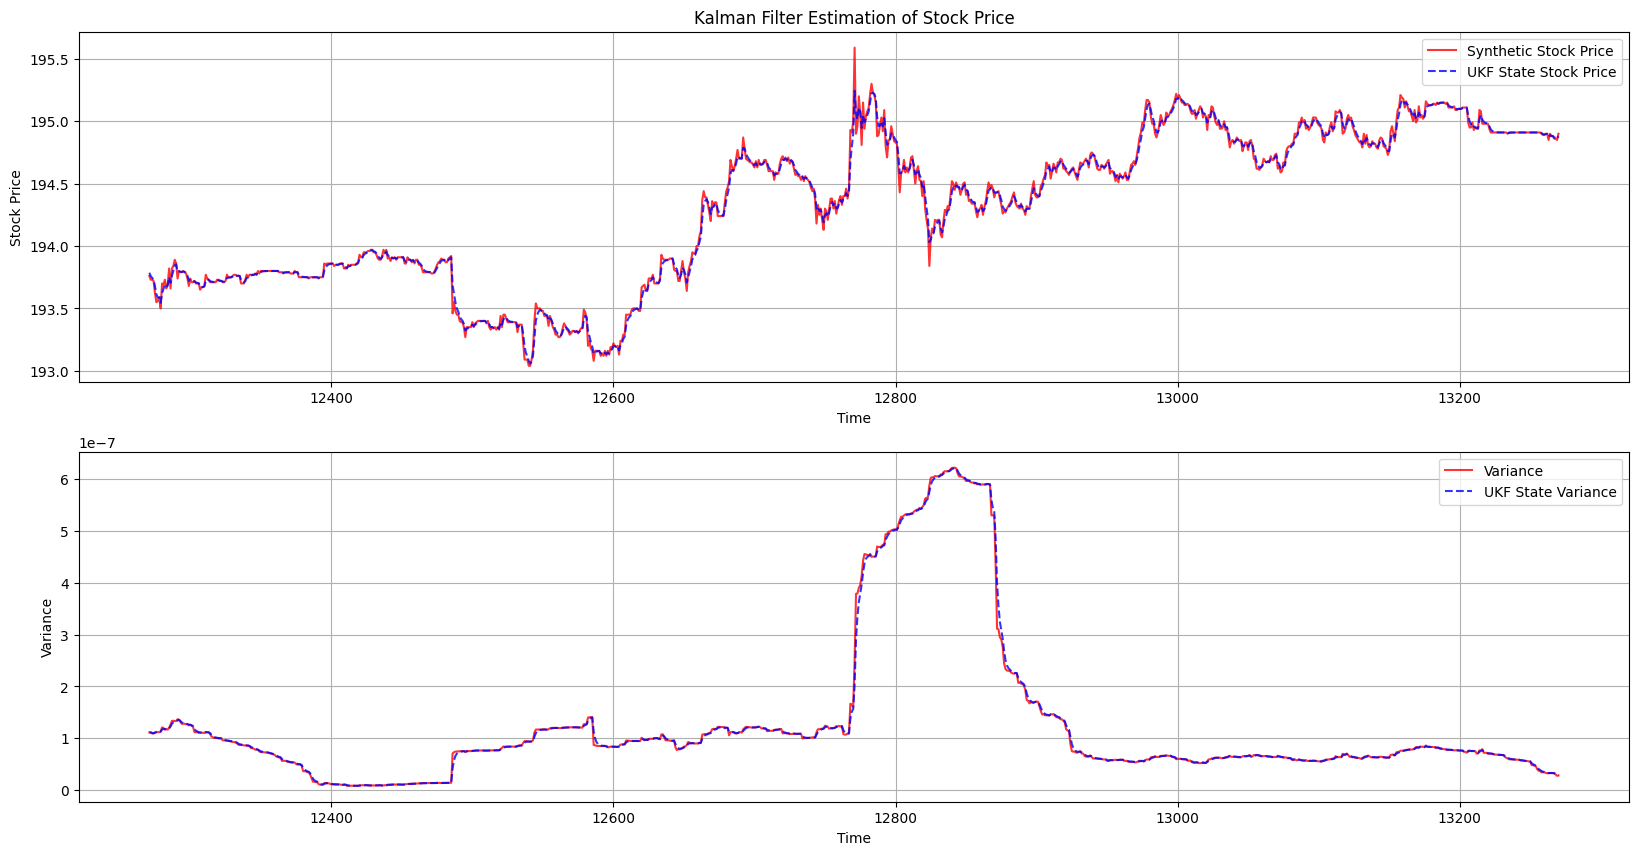

In [46]:

N = 1000
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].set_title("Kalman Filter Estimation of Stock Price")

ax[0].plot(
    df.index[-N:], df.prices[-N:], color="red", label="Synthetic Stock Price", alpha=0.8
)
ax[0].plot(
    df.index[-N:],
    X_hat[-N:, 0],
    color="blue",
    label="UKF State Stock Price",
    alpha=0.8,
    linestyle="--",
)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Stock Price")
ax[0].legend()
ax[0].grid()

ax[1].plot(
    df.index[-N:], df.variance[-N:], color="red", label="Variance", alpha=0.8
)
ax[1].plot(
    df.index[-N:],
    X_hat[-N:, -1],
    color="blue",
    label="UKF State Variance",
    alpha=0.8,
    linestyle="--",
)
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Variance")
ax[1].legend()
ax[1].grid()

## Our SSM


In [6]:
from typing import List
from filters.ssm import DSSM

# order [kappa, theta, xi, rho, mu, p, ]
LEARNABLE_PARAMS = [20, 0.0729, 0.01, -0.3, 0.3, 0.5]


hdssm = HestonDSSM(LEARNABLE_PARAMS)

## Heston SSM


In [47]:
ukf = UnscentedKalmanFilter(
    dim_x=2,
    dim_z=2,
    Q=np.array([[1.0, 0.0], [0.0, 1.0]]),
    R=np.array([[1.0, 0.0], [0.0, 1.0]]),
)

X_hat, _, X_hat_estim = ukf.fit_predict(
    state_function=hdssm.f,
    observation_function=hdssm.h,
    z=Z,
    u=np.stack(
        StochasticModels.generate_two_correlated_brownian(-0.3, Z.shape[0]), axis=1
    ),
    x0=df[["variance", "prices"]].dropna().to_numpy()[0],
    verbose=True,
    keep_state_estimates=True,
)

UKF:   0%|          | 33/13270 [00:00<00:40, 324.70it/s]

P=[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
P=[[2.75585256e+02 5.10372977e-16 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.10372977e-16 2.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]
y_sigmas=[[   8.22292043   10.86867174    8.22292043    8.22292043    8.22292043
    10.86867174    8.22292043    5.57716912    8.22292043    8.22292043
     8.22292043    5.57716912    8.22292043]
 [-620.30744533 -883.55307561 -628.99553022 -620.30744533 -620.30744533
  -620.30744533 -617.6616940

UKF:   1%|          | 92/13270 [00:00<00:55, 237.82it/s]

[1.88350000e+02 1.74713363e-07] 
y= [2.48038245e+72 2.16088207e+11]
P=[[ 1.53914087e+113 -2.05070340e-004  0.00000000e+000  0.00000000e+000
   0.00000000e+000  0.00000000e+000]
 [-2.05070340e-004  1.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000  0.00000000e+000]
 [ 0.00000000e+000  0.00000000e+000  1.00000000e+000  0.00000000e+000
   0.00000000e+000  0.00000000e+000]
 [ 0.00000000e+000  0.00000000e+000  0.00000000e+000  1.00000000e+000
   0.00000000e+000  0.00000000e+000]
 [ 0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
   1.00000000e+000  0.00000000e+000]
 [ 0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000  1.00000000e+000]]
P=[[ 1.57608025e+116 -4.03196654e+011  0.00000000e+000  0.00000000e+000
   0.00000000e+000  0.00000000e+000]
 [-4.03196654e+011  2.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000  0.00000000e+000]
 [ 0.00000000e+000  0.00000000e+000  1.00000000e+000  0.00000000e+000
 

UKF:   1%|          | 117/13270 [00:00<00:56, 232.21it/s]c:\_sharedFS\Ecole\Gestion Quantitative\Forecasting-high-low-with-Kalman-filters\src\filters\unscented_kalman_filter.py:265: RuntimeWarning: overflow encountered in matmul
  Pyy += self.Wi * (d @ d.T)
c:\_sharedFS\Ecole\Gestion Quantitative\Forecasting-high-low-with-Kalman-filters\src\filters\unscented_kalman_filter.py:208: RuntimeWarning: invalid value encountered in matmul
  P = P - (K @ Pyy @ K.T)
UKF:   1%|          | 123/13270 [00:00<00:55, 237.14it/s]


y_sigmas=[[ 1.92076354e+145  1.92076354e+145  1.92076354e+145  1.92076354e+145
   1.92076354e+145  1.92076354e+145  1.92076354e+145  1.92076354e+145
   1.92076354e+145  1.92076354e+145  1.92076354e+145  1.92076354e+145
   1.92076354e+145]
 [-8.12386493e+088 -8.12386493e+088 -2.54093133e+145 -8.12386493e+088
  -8.12386493e+088 -8.12386493e+088 -8.12386493e+088 -8.12386493e+088
   2.54093133e+145 -8.12386493e+088 -8.12386493e+088 -8.12386493e+088
  -8.12386493e+088]]
x= [1.92076354e+145 8.45899535e-057] 
K= [[ 0.00000000e+000  0.00000000e+000]
 [ 0.00000000e+000 -1.04125258e-145]] 
z= [1.86650000e+02 7.20751965e-07] 
y= [ 1.92076354e+145 -2.32110426e+088]
P=[[0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
P=[[ 1.96805049e+261 -3.28219243e+073  0.00000000e+000  0.00000000e+000
   0.00000000e+000  0.00000000e+000]
 [-3.28219243e+073  2.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000  0.00000000

ValueError: array must not contain infs or NaNs

In [ ]:
N = 1000
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].set_title("Kalman Filter Estimation of Stock Price")

ax[0].plot(
    df.Date[-N:], df.prices[-N:], color="red", label="Synthetic Stock Price", alpha=0.8
)
axl = ax[0].twinx()
axl.plot(
    df.Date[-N:],
    X_hat[-N:, 1],
    color="blue",
    label="UKF State Stock Price",
    alpha=0.8,
    linestyle="--",
)
# ax[0].plot(
#     df.Date[-N:],
#     X_hat_estim[-N:, 1],
#     color="green",
#     label="UKF State Stock Price estimated only",
#     alpha=0.8,
#     linestyle="--",
# )

# ax[0].set_xlabel("Time")
# ax[0].set_ylabel("Stock Price")
# ax[0].legend()
# ax[0].grid()

# ax[1].plot(
#     df.Date[-N:], df.vol[-N:], color="red", label="Stochastic Volatility", alpha=0.8
# )

# ax[1].plot(
#     df.Date[-N:],
#     X_hat[-N:, 0],
#     color="blue",
#     label="UKF State Volatility",
#     alpha=0.8,
#     linestyle="--",
# )
# ax[1].plot(
#     df.Date[-N:],
#     X_hat_estim[-N:, 0],
#     color="green",
#     label="UKF State Volatility estimated only",
#     alpha=0.8,
#     linestyle="--",
# )


# ax[1].set_xlabel("Time")
# ax[1].set_ylabel("Volatility")
# ax[1].legend()
# ax[1].grid()

# Article SSM


In [ ]:
# df["prices_t_1"] = df.prices.shift(1)
# Z = df[["vol", "prices", "prices_t_1"]].dropna().to_numpy()

In [ ]:
LEARNABLE_PARAMS = [4, 0.27, 0.99, -0.3, 0.3, 0.5]

dssm = DSSM(LEARNABLE_PARAMS)

In [ ]:
ukf = UnscentedKalmanFilter(
    dim_x=3,
    dim_z=3,
    Q=np.array([[10, 0.0, 0.0], [0.0, 10.0, 0.0], [0.0, 0.0, 10.0]]),
    R=np.array([[5, 0.0, 0.0], [0.0, 5.0, 0.0], [0.0, 0.0, 5.0]]),
)

X_hat, _, X_hat_estim = ukf.fit_predict(
    dssm.f,
    dssm.h,
    z=Z,
    u=np.stack(
        StochasticModels.generate_two_correlated_brownian(-0.3, Z.shape[0]), axis=1
    ),
    x0=df[["vol", "prices", "prices_t_1"]].dropna().to_numpy()[0],
    verbose=False,
    keep_state_estimates=True,
)

In [ ]:
N = 100
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].set_title("Kalman Filter Estimation of Stock Price")

ax[0].plot(
    df.t[-N:], df.prices[-N:], color="red", label="Synthetic Stock Price", alpha=0.8
)
ax[0].plot(
    df.t[-N:],
    X_hat[-N:, 1],
    color="blue",
    label="UKF State Stock Price",
    alpha=0.8,
    linestyle="--",
)
ax[0].plot(
    df.t[-N:],
    X_hat_estim[-N:, 1],
    color="green",
    label="UKF State Stock Price estimated only",
    alpha=0.8,
    linestyle="--",
)

ax[0].set_xlabel("Time")
ax[0].set_ylabel("Stock Price")
ax[0].legend()
ax[0].grid()

ax[1].plot(
    df.t[-N:], df.vol[-N:], color="red", label="Stochastic Volatility", alpha=0.8
)

ax[1].plot(
    df.t[-N:],
    X_hat[-N:, 0],
    color="blue",
    label="UKF State Volatility",
    alpha=0.8,
    linestyle="--",
)
ax[1].plot(
    df.t[-N:],
    X_hat_estim[-N:, 0],
    color="green",
    label="UKF State Volatility estimated only",
    alpha=0.8,
    linestyle="--",
)


ax[1].set_xlabel("Time")
ax[1].set_ylabel("Volatility")
ax[1].legend()
ax[1].grid()